In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import boto3
import io
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
import re
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier

The dataset comes from *Open Food Facts* and was downloaded from: https://www.kaggle.com/openfoodfacts/world-food-facts/home.
'Open Food Facts is a free, open, collbarative database of food products from around the world, with ingredients, allergens, nutrition facts and all the tidbits of information we can find on product labels. Open Food Facts is a non-profit association of volunteers.' Over 5,000 contributors 'have added 100 000+ products from 150 countries using our Android, iPhone or Windows Phone app or their camera to scan barcodes and upload pictures of products and their labels.'

# DATA UPLOAD

food = pd.read_csv(r'/Users/admin/Documents/food.tsv', delimiter = '\t', encoding='ISO-8859-1')

In [2]:
#s3 data

s3 = boto3.client('s3') 
obj = s3.get_object(Bucket='innawendell', Key='food.tsv') 
food = pd.read_csv(io.BytesIO(obj['Body'].read()), delimiter = '\t', encoding='ISO-8859-1')

In [3]:
food.shape

(356027, 163)

In [4]:
pd.set_option('display.max_columns', 500)
food.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,no_nutriments,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_uk,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,main_category,main_category_en,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blÃ© noir,NaN,1kg,NaN,NaN,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","To be completed,Nutrition facts to be complete...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,United States,"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,Na

In [5]:
food_nutrition = food.loc[:, ['url','product_name', 'ingredients_text','energy_100g', 'fat_100g','saturated_fat_100g','trans_fat_100g','cholesterol_100g','additives_n', 'omega_3_fat_100',  
     'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'fiber_100g','sodium_100', 'alcohol_100g', 'vitamin_a_100g',
     'vitamin_d_100g', 'vitamin_e_100g', 'vitamin_k_100g', 'vitamin_c_100g', 'vitamin_b1_100g', 'vitamin_b2_100g', 'vitamin_b6_100g',
      'vitamin_b12_100g', 'phosphorus_100g','calcium_100', 'iron_100g', 'manganese_100g', 'iodine_10',
     'magnesium_100g', 'zinc_100g', 'pnns_groups_1', 'serving_size']]  

In [6]:
food_nutrition.head()

,url,product_name,ingredients_text,energy_100g,fat_100g,saturated_fat_100g,trans_fat_100g,cholesterol_100g,additives_n,omega_3_fat_100,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,fiber_100g,sodium_100,alcohol_100g,vitamin_a_100g,vitamin_d_100g,vitamin_e_100g,vitamin_k_100g,vitamin_c_100g,vitamin_b1_100g,vitamin_b2_100g,vitamin_b6_100g,vitamin_b12_100g,phosphorus_100g,calcium_100,iron_100g,manganese_100g,iodine_10,magnesium_100g,zinc_100g,pnns_groups_1,serving_size
0,http://world-en.openfoodfacts.org/product/0000...,Farine de blÃ© noir,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,http://world-en.openfoodfacts.org/product/0000...,Banana Chips Sweetened (Whole),"Bananas, vegetable oil (coconut oil, corn oil ...",2243.0,28.57,NaN,NaN,0.018,0.0,NaN,64.29,14.29,3.57,0.00000,3.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00129,NaN,NaN,NaN,NaN,NaN,28 g (1 ONZ)
2,http://world-en.openfoodfacts.org/product/0000...,Peanuts,"Peanuts, wheat flour, sugar, rice flour, tapio...",1941.0,17.86,NaN,NaN,0.000,0.0,NaN,60.71,17.86,17.86,0.63500,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00129,NaN,NaN,NaN,NaN,NaN,28 g (0.25 cup)
3,http://world-en.openfoodfacts.org/product/0000...,Organic Salted Nut Mix,"Organic hazelnuts, organic cashews, organic wa...",2540.0,57.14,NaN,NaN,NaN,0.0,NaN,17.86,3.57,17.86,1.22428,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00514,NaN,NaN,NaN,NaN,NaN,28 g (0.25 cup)
4,http://world-en.openfoodfacts.org/product/0000...,Organic Polenta,Organic polenta,1552.0,1.43,NaN,NaN,NaN,0.0,NaN,77.14,NaN,8.57,NaN,5.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35 g (0.25 cup)


In [7]:
# examining urls made us think that the majority of the nan values are not present in the nutritional makeup of a product
food_nutrition =food_nutrition.fillna(0)

In [8]:
def change_category(row):
    if row['pnns_groups_1'] == 0:
        return 'unknown'
    else:
        return row['pnns_groups_1']

In [9]:
food_nutrition['pnns_groups_1'] = food_nutrition.apply(change_category, axis=1) 

In [10]:
food_nutrition['pnns_groups_1'].value_counts()

unknown                    270624
Sugary snacks               14750
Beverages                   13476
Milk and dairy products     10733
Cereals and potatoes        10078
Fish Meat Eggs               9473
Composite foods              7972
Fat and sauces               7122
Fruits and vegetables        6763
Salty snacks                 3299
fruits-and-vegetables        1098
sugary-snacks                 619
cereals-and-potatoes           19
salty-snacks                    1
Name: pnns_groups_1, dtype: int64

In [11]:
#fix alternative spelling
food_nutrition.loc[food_nutrition['pnns_groups_1']=='salty-snacks'] ='Salty snacks'   
food_nutrition.loc[food_nutrition['pnns_groups_1']=='fruits-and-vegetables'] ='Fruits and vegetables' 
food_nutrition.loc[food_nutrition['pnns_groups_1']=='sugary-snacks'] ='Sugary snacks' 
food_nutrition.loc[food_nutrition['pnns_groups_1']=='cereals-and-potatoes'] ='Cereals and potatoes' 

In [12]:
food_nutrition['pnns_groups_1'].value_counts()

unknown                    270624
Sugary snacks               15369
Beverages                   13476
Milk and dairy products     10733
Cereals and potatoes        10097
Fish Meat Eggs               9473
Composite foods              7972
Fruits and vegetables        7861
Fat and sauces               7122
Salty snacks                 3300
Name: pnns_groups_1, dtype: int64

In [13]:
food_nutrition.head()

,url,product_name,ingredients_text,energy_100g,fat_100g,saturated_fat_100g,trans_fat_100g,cholesterol_100g,additives_n,omega_3_fat_100,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,fiber_100g,sodium_100,alcohol_100g,vitamin_a_100g,vitamin_d_100g,vitamin_e_100g,vitamin_k_100g,vitamin_c_100g,vitamin_b1_100g,vitamin_b2_100g,vitamin_b6_100g,vitamin_b12_100g,phosphorus_100g,calcium_100,iron_100g,manganese_100g,iodine_10,magnesium_100g,zinc_100g,pnns_groups_1,serving_size
0,http://world-en.openfoodfacts.org/product/0000...,Farine de blÃ© noir,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,unknown,0
1,http://world-en.openfoodfacts.org/product/0000...,Banana Chips Sweetened (Whole),"Bananas, vegetable oil (coconut oil, corn oil ...",2243,28.57,0,0,0.018,0,0,64.29,14.29,3.57,0,3.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00129,0,0,0,0,unknown,28 g (1 ONZ)
2,http://world-en.openfoodfacts.org/product/0000...,Peanuts,"Peanuts, wheat flour, sugar, rice flour, tapio...",1941,17.86,0,0,0,0,0,60.71,17.86,17.86,0.635,7.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00129,0,0,0,0,unknown,28 g (0.25 cup)
3,http://world-en.openfoodfacts.org/product/0000...,Organic Salted Nut Mix,"Organic hazelnuts, organic cashews, organic wa...",2540,57.14,0,0,0,0,0,17.86,3.57,17.86,1.22428,7.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00514,0,0,0,0,unknown,28 g (0.25 cup)
4,http://world-en.openfoodfacts.org/product/0000...,Organic Polenta,Organic polenta,1552,1.43,0,0,0,0,0,77.14,0,8.57,0,5.7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,unknown,35 g (0.25 cup)


In [14]:
food_nutrition_cats = food_nutrition[food_nutrition['pnns_groups_1'] != 'unknown']

# Adding Serving Size

## Regex

In [15]:
food_nutrition.head()

,url,product_name,ingredients_text,energy_100g,fat_100g,saturated_fat_100g,trans_fat_100g,cholesterol_100g,additives_n,omega_3_fat_100,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,fiber_100g,sodium_100,alcohol_100g,vitamin_a_100g,vitamin_d_100g,vitamin_e_100g,vitamin_k_100g,vitamin_c_100g,vitamin_b1_100g,vitamin_b2_100g,vitamin_b6_100g,vitamin_b12_100g,phosphorus_100g,calcium_100,iron_100g,manganese_100g,iodine_10,magnesium_100g,zinc_100g,pnns_groups_1,serving_size
0,http://world-en.openfoodfacts.org/product/0000...,Farine de blÃ© noir,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,unknown,0
1,http://world-en.openfoodfacts.org/product/0000...,Banana Chips Sweetened (Whole),"Bananas, vegetable oil (coconut oil, corn oil ...",2243,28.57,0,0,0.018,0,0,64.29,14.29,3.57,0,3.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00129,0,0,0,0,unknown,28 g (1 ONZ)
2,http://world-en.openfoodfacts.org/product/0000...,Peanuts,"Peanuts, wheat flour, sugar, rice flour, tapio...",1941,17.86,0,0,0,0,0,60.71,17.86,17.86,0.635,7.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00129,0,0,0,0,unknown,28 g (0.25 cup)
3,http://world-en.openfoodfacts.org/product/0000...,Organic Salted Nut Mix,"Organic hazelnuts, organic cashews, organic wa...",2540,57.14,0,0,0,0,0,17.86,3.57,17.86,1.22428,7.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00514,0,0,0,0,unknown,28 g (0.25 cup)
4,http://world-en.openfoodfacts.org/product/0000...,Organic Polenta,Organic polenta,1552,1.43,0,0,0,0,0,77.14,0,8.57,0,5.7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,unknown,35 g (0.25 cup)


In [16]:
food_nutrition.dtypes

url                   object
product_name          object
ingredients_text      object
energy_100g           object
fat_100g              object
saturated_fat_100g    object
trans_fat_100g        object
cholesterol_100g      object
additives_n           object
omega_3_fat_100       object
carbohydrates_100g    object
sugars_100g           object
proteins_100g         object
salt_100g             object
fiber_100g            object
sodium_100            object
alcohol_100g          object
vitamin_a_100g        object
vitamin_d_100g        object
vitamin_e_100g        object
vitamin_k_100g        object
vitamin_c_100g        object
vitamin_b1_100g       object
vitamin_b2_100g       object
vitamin_b6_100g       object
vitamin_b12_100g      object
phosphorus_100g       object
calcium_100           object
iron_100g             object
manganese_100g        object
iodine_10             object
magnesium_100g        object
zinc_100g             object
pnns_groups_1         object
serving_size  

In [17]:
food_nutrition['serving_size'].dtype

dtype('O')

In [18]:
mls = []
pattern = re.compile(r'\d+\s([m][l])')
pattern_two = re.compile(r'\d+\s([m][L])')
pattern_three = re.compile(r'\d+\s([g])')
pattern_four = re.compile(r'\d+\S([g])')

for entry in food_nutrition['serving_size']:
    try:
        mls.append(pattern.match(str(entry)).group())
    except AttributeError:
        mls.append(0)

In [19]:
mLs= []
for entry in food_nutrition['serving_size']:
    try:
        mLs.append(pattern_two.match(str(entry)).group())
    except AttributeError:
        mLs.append(0)

In [20]:
gspace =[]
for entry in food_nutrition['serving_size']:
    try:
        gspace.append(pattern_three.match(str(entry)).group())
    except AttributeError:
        gspace.append(0)

In [21]:
g_no_space = []
for entry in food_nutrition['serving_size']:
    try:
        g_no_space.append(pattern_four.match(str(entry)).group())
    except AttributeError:
        g_no_space.append(0)

In [22]:
# matches decimals
pattern_five = re.compile(r'\d+(\.\d{1,2})\s([g])')
gr_dec = []

for entry in food_nutrition['serving_size']:
    try:
        gr_dec.append(pattern_five.match(str(entry)).group())
    except AttributeError:
        gr_dec.append(0)

In [23]:
food_nutrition['ml'] = mls
food_nutrition['mL'] = mLs
food_nutrition['gram_space'] = gspace 
food_nutrition['gram_no_space'] = g_no_space
food_nutrition['gram_decimal'] = gr_dec

In [24]:
#write a transformation function for all rows
def transform(row):
    if row['ml'] != 0:
        return row['ml']
    elif row['mL'] != 0:
        return row['mL']
    elif row['gram_space'] !=0:
        return row['gram_space']
    elif row['gram_no_space'] !=0:
        return row['gram_no_space']
    elif row['gram_decimal'] !=0:
           return row['gram_decimal']
    else:
        return 0

In [25]:
food_nutrition['serving'] = food_nutrition.apply(transform, axis=1) 

In [26]:
food_nutrition.head()

,url,product_name,ingredients_text,energy_100g,fat_100g,saturated_fat_100g,trans_fat_100g,cholesterol_100g,additives_n,omega_3_fat_100,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,fiber_100g,sodium_100,alcohol_100g,vitamin_a_100g,vitamin_d_100g,vitamin_e_100g,vitamin_k_100g,vitamin_c_100g,vitamin_b1_100g,vitamin_b2_100g,vitamin_b6_100g,vitamin_b12_100g,phosphorus_100g,calcium_100,iron_100g,manganese_100g,iodine_10,magnesium_100g,zinc_100g,pnns_groups_1,serving_size,ml,mL,gram_space,gram_no_space,gram_decimal,serving
0,http://world-en.openfoodfacts.org/product/0000...,Farine de blÃ© noir,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,unknown,0,0,0,0,0,0,0
1,http://world-en.openfoodfacts.org/product/0000...,Banana Chips Sweetened (Whole),"Bananas, vegetable oil (coconut oil, corn oil ...",2243,28.57,0,0,0.018,0,0,64.29,14.29,3.57,0,3.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00129,0,0,0,0,unknown,28 g (1 ONZ),0,0,28 g,0,0,28 g
2,http://world-en.openfoodfacts.org/product/0000...,Peanuts,"Peanuts, wheat flour, sugar, rice flour, tapio...",1941,17.86,0,0,0,0,0,60.71,17.86,17.86,0.635,7.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00129,0,0,0,0,unknown,28 g (0.25 cup),0,0,28 g,0,0,28 g
3,http://world-en.openfoodfacts.org/product/0000...,Organic Salted Nut Mix,"Organic hazelnuts, organic cashews, organic wa...",2540,57.14,0,0,0,0,0,17.86,3.57,17.86,1.22428,7.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00514,0,0,0,0,unknown,28 g (0.25 cup),0,0,28 g,0,0,28 g
4,http://world-en.openfoodfacts.org/product/0000...,Organic Polenta,Organic polenta,1552,1.43,0,0,0,0,0,77.14,0,8.57,0,5.7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,unknown,35 g (0.25 cup),0,0,35 g,0,0,35 g


In [27]:
food_nutrition = food_nutrition.drop(['serving_size', 'ml', 'mL', 'gram_space', 'gram_no_space', 'gram_decimal'], axis=1)

In [28]:
#grams function
def parse_rows(row):
    if str(row['serving']).count('g') >0:
        return 1
    else:
        return 0

In [29]:
#mls function
def parse_rows_ml(row):
    if str(row['serving']).count('ml') >0:
        return 1
    else:
        return 0

In [30]:
food_nutrition['grams'] = food_nutrition.apply(parse_rows, axis=1)

In [31]:
food_nutrition['mls'] = food_nutrition.apply(parse_rows_ml, axis=1) 

In [32]:
food_nutrition.head()

,url,product_name,ingredients_text,energy_100g,fat_100g,saturated_fat_100g,trans_fat_100g,cholesterol_100g,additives_n,omega_3_fat_100,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,fiber_100g,sodium_100,alcohol_100g,vitamin_a_100g,vitamin_d_100g,vitamin_e_100g,vitamin_k_100g,vitamin_c_100g,vitamin_b1_100g,vitamin_b2_100g,vitamin_b6_100g,vitamin_b12_100g,phosphorus_100g,calcium_100,iron_100g,manganese_100g,iodine_10,magnesium_100g,zinc_100g,pnns_groups_1,serving,grams,mls
0,http://world-en.openfoodfacts.org/product/0000...,Farine de blÃ© noir,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,unknown,0,0,0
1,http://world-en.openfoodfacts.org/product/0000...,Banana Chips Sweetened (Whole),"Bananas, vegetable oil (coconut oil, corn oil ...",2243,28.57,0,0,0.018,0,0,64.29,14.29,3.57,0,3.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00129,0,0,0,0,unknown,28 g,1,0
2,http://world-en.openfoodfacts.org/product/0000...,Peanuts,"Peanuts, wheat flour, sugar, rice flour, tapio...",1941,17.86,0,0,0,0,0,60.71,17.86,17.86,0.635,7.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00129,0,0,0,0,unknown,28 g,1,0
3,http://world-en.openfoodfacts.org/product/0000...,Organic Salted Nut Mix,"Organic hazelnuts, organic cashews, organic wa...",2540,57.14,0,0,0,0,0,17.86,3.57,17.86,1.22428,7.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00514,0,0,0,0,unknown,28 g,1,0
4,http://world-en.openfoodfacts.org/product/0000...,Organic Polenta,Organic polenta,1552,1.43,0,0,0,0,0,77.14,0,8.57,0,5.7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,unknown,35 g,1,0


In [33]:
def replace(row):
    if str(row['serving']).count('g') >0:
        return str(row['serving']).replace('g','')
    elif str(row['serving']).count('ml') >0:
        return str(row['serving']).replace('ml', '')
    elif str(row['serving']).count('mL') >0:
        return str(row['serving']).replace('mL', '')

In [34]:
# getting rid of the mls or g in the serving column since we creating binary features for grams and mls
food_nutrition['serving'] = food_nutrition.apply(replace, axis=1) 

In [35]:
food_nutrition_cats = food_nutrition[food_nutrition['pnns_groups_1'] != 'unknown']

In [36]:
food_nutrition_cats.dtypes

url                   object
product_name          object
ingredients_text      object
energy_100g           object
fat_100g              object
saturated_fat_100g    object
trans_fat_100g        object
cholesterol_100g      object
additives_n           object
omega_3_fat_100       object
carbohydrates_100g    object
sugars_100g           object
proteins_100g         object
salt_100g             object
fiber_100g            object
sodium_100            object
alcohol_100g          object
vitamin_a_100g        object
vitamin_d_100g        object
vitamin_e_100g        object
vitamin_k_100g        object
vitamin_c_100g        object
vitamin_b1_100g       object
vitamin_b2_100g       object
vitamin_b6_100g       object
vitamin_b12_100g      object
phosphorus_100g       object
calcium_100           object
iron_100g             object
manganese_100g        object
iodine_10             object
magnesium_100g        object
zinc_100g             object
pnns_groups_1         object
serving       

In [37]:
#Since 'm' is not a clear metric, we will remove it from the analysis.
food_nutrition_cats = food_nutrition_cats[food_nutrition_cats['serving']!= '1000m']

In [38]:
food_nutrition_cats = food_nutrition_cats.dropna(how='any')

In [39]:
y = food_nutrition_cats['pnns_groups_1']

In [40]:
X = food_nutrition_cats[['energy_100g', 'fat_100g','saturated_fat_100g','trans_fat_100g','cholesterol_100g','additives_n', 'omega_3_fat_100',  
     'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'fiber_100g','sodium_100', 'alcohol_100g', 'vitamin_a_100g',
     'vitamin_d_100g', 'vitamin_e_100g', 'vitamin_k_100g', 'vitamin_c_100g', 'vitamin_b1_100g', 'vitamin_b2_100g', 'vitamin_b6_100g',
      'vitamin_b12_100g', 'phosphorus_100g','calcium_100', 'iron_100g', 'manganese_100g', 'iodine_10',
     'magnesium_100g', 'zinc_100g', 'serving']]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=108)

## Scaling the Numerical Features

In [42]:
from sklearn import preprocessing
X_train[['energy_100g', 'fat_100g','saturated_fat_100g','trans_fat_100g','cholesterol_100g','additives_n', 'omega_3_fat_100',  
     'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'fiber_100g','sodium_100', 'alcohol_100g', 'vitamin_a_100g',
     'vitamin_d_100g', 'vitamin_e_100g', 'vitamin_k_100g', 'vitamin_c_100g', 'vitamin_b1_100g', 'vitamin_b2_100g', 'vitamin_b6_100g',
      'vitamin_b12_100g', 'phosphorus_100g','calcium_100', 'iron_100g', 'manganese_100g', 'iodine_10',
     'magnesium_100g', 'zinc_100g', 'serving']] = preprocessing.scale(X_train[['energy_100g', 'fat_100g','saturated_fat_100g','trans_fat_100g',
    'cholesterol_100g','additives_n', 'omega_3_fat_100',  
     'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'fiber_100g','sodium_100', 'alcohol_100g', 'vitamin_a_100g',
     'vitamin_d_100g', 'vitamin_e_100g', 'vitamin_k_100g', 'vitamin_c_100g', 'vitamin_b1_100g', 'vitamin_b2_100g', 'vitamin_b6_100g',
      'vitamin_b12_100g', 'phosphorus_100g','calcium_100', 'iron_100g', 'manganese_100g', 'iodine_10',
     'magnesium_100g', 'zinc_100g', 'serving']].astype(np.float64), copy=False)

# Random Forest Classifier

In [43]:
n_est = []
accuracy_rfc = []

for value in [100, 500,700]:
    rfc = RandomForestClassifier(n_estimators = value)
    accuracy_rfc.append(np.mean(cross_val_score(rfc, X_train, y_train, scoring='accuracy', n_jobs=-1)))
    n_est.append(value)

In [44]:
df_rfc_one = pd.DataFrame(accuracy_rfc, columns = ['accuracy'])
df_rfc_one['n_estimators'] = n_est
df_rfc_one.sort_values(by=['accuracy'], ascending=False)

,accuracy,n_estimators
1,0.903396,500
2,0.902747,700
0,0.901030,100


In [45]:
max_depth = []
accuracy_rfc = []

for value in [8, 12, 20, 50]:
    rfc = RandomForestClassifier(n_jobs=-1, max_depth = value, n_estimators=500)
    accuracy_rfc.append(np.mean(cross_val_score(rfc, X_train, y_train, scoring='accuracy')))
    max_depth.append(value)

In [46]:
df_rfc_three = pd.DataFrame(accuracy_rfc, columns = ['accuracy'])
df_rfc_three['max_depth'] = max_depth
df_rfc_three.sort_values(by=['accuracy'], ascending=False)

,accuracy,max_depth
2,0.902747,20
3,0.902468,50
1,0.887574,12
0,0.853192,8


## XGB Classifier

In [47]:
xgb = XGBClassifier()

#X_train.columns =np.arange(0,3681, 1)
n_est = []
accuracy_xgb = []
for value in [100, 500,700]:
    xgb = XGBClassifier(n_jobs = -1,  n_estimators = value, booster= 'gbtree')
    accuracy_xgb.append(np.mean(cross_val_score(xgb, X_train, y_train, scoring='accuracy')))
    n_est.append(value)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

In [48]:
df_xgb = pd.DataFrame(accuracy_xgb, columns = ['accuracy'])
df_xgb['n_est'] = n_est
df_xgb.sort_values(by=['accuracy'], ascending=False)

,accuracy,n_est
2,0.895415,700
1,0.893791,500
0,0.868829,100


In [49]:
max_depth = []
accuracy_xgb = []

for value in [2, 4, 6, 8]:
    xgb = XGBClassifier(n_jobs = -1,  n_estimators = 700, booster= 'gbtree', max_depth = value)
    accuracy_xgb.append(np.mean(cross_val_score(xgb, X_train, y_train, scoring='accuracy')))
    max_depth.append(value)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

In [50]:
df_xgb = pd.DataFrame(accuracy_xgb, columns = ['accuracy'])
df_xgb['max_depth'] = max_depth
df_xgb.sort_values(by=['accuracy'], ascending=False)

,accuracy,max_depth
3,0.903164,8
2,0.902932,6
1,0.898524,4
0,0.884697,2


# Test Set Validation

In [51]:
X_test[['energy_100g', 'fat_100g','saturated_fat_100g','trans_fat_100g','cholesterol_100g','additives_n', 'omega_3_fat_100',  
     'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'fiber_100g','sodium_100', 'alcohol_100g', 'vitamin_a_100g',
     'vitamin_d_100g', 'vitamin_e_100g', 'vitamin_k_100g', 'vitamin_c_100g', 'vitamin_b1_100g', 'vitamin_b2_100g', 'vitamin_b6_100g',
      'vitamin_b12_100g', 'phosphorus_100g','calcium_100', 'iron_100g', 'manganese_100g', 'iodine_10',
     'magnesium_100g', 'zinc_100g', 'serving']] = preprocessing.scale(X_test[['energy_100g', 'fat_100g','saturated_fat_100g','trans_fat_100g',
    'cholesterol_100g','additives_n', 'omega_3_fat_100',  
     'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'fiber_100g','sodium_100', 'alcohol_100g', 'vitamin_a_100g',
     'vitamin_d_100g', 'vitamin_e_100g', 'vitamin_k_100g', 'vitamin_c_100g', 'vitamin_b1_100g', 'vitamin_b2_100g', 'vitamin_b6_100g',
      'vitamin_b12_100g', 'phosphorus_100g','calcium_100', 'iron_100g', 'manganese_100g', 'iodine_10',
     'magnesium_100g', 'zinc_100g', 'serving']].astype(np.float64), copy=False)

### Random Forest

In [52]:
forest_best = RandomForestClassifier(n_jobs=-1, max_depth = 20, n_estimators=500)
forest_fit = forest_best.fit(X_train, y_train)
forest_pred = forest_best.predict(X_test)
forest_best.score(X_test, y_test)

0.8724944320712695

In [56]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, forest_pred)

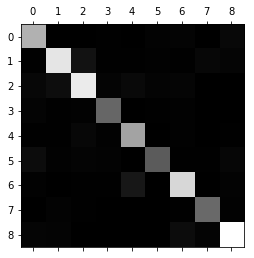

In [61]:
plt.matshow(matrix, cmap = plt.cm.gray)
plt.show()

In [64]:
forest_best.classes_

array(['Beverages', 'Cereals and potatoes', 'Composite foods',
       'Fat and sauces', 'Fish Meat Eggs', 'Fruits and vegetables',
       'Milk and dairy products', 'Salty snacks', 'Sugary snacks'],
      dtype=object)

In [67]:
row_sums = matrix.sum(axis=1,keepdims=True)
norm_conf_mx = matrix / row_sums

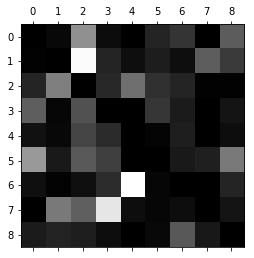

In [73]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

### XGB Classifier

In [54]:
xgb_best = XGBClassifier(n_jobs=-1, max_depth = 8, n_estimators=700)
xgb_fit = xgb_best.fit(X_train, y_train)
xgb_pred = xgb_best.predict(X_test)
xgb_best.score(X_test, y_test)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8427988121752041

In [62]:
matrix_xgb = confusion_matrix(y_test, xgb_pred)

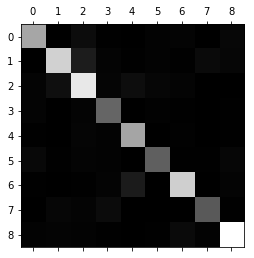

In [63]:
plt.matshow(matrix_xgb, cmap = plt.cm.gray)
plt.show()

In [65]:
xgb_best.classes_

array(['Beverages', 'Cereals and potatoes', 'Composite foods',
       'Fat and sauces', 'Fish Meat Eggs', 'Fruits and vegetables',
       'Milk and dairy products', 'Salty snacks', 'Sugary snacks'],
      dtype=object)

In [72]:
row_sums = matrix_xgb.sum(axis=1,keepdims=True)
norm_conf_mx = matrix_xgb / row_sums

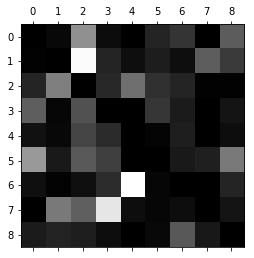

In [74]:
np.fill_diagonal(matrix_xgb, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()